In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model #imports

import matplotlib.pyplot as plt #imports

In [2]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

#Dataset paths
path = 'drive/MyDrive/AgriLifeMicrohistologicalProject/SubImages'
#path = 'drive/MyDrive/AgriLifeMicrohistologicalProject/FeatureImages'
newpath = 'drive/MyDrive/AgriLifeMicrohistologicalProject/NewImages'
fivepath = 'drive/MyDrive/AgriLifeMicrohistologicalProject/fivetestfeatures'

Mounted at /content/drive


In [3]:
def plotimg(images_arr, num_img):
  # Create a figure and axes.
  fig, axes = plt.subplots(1, num_img)
  # Flatten the axes array to easily iterate.
  axes = axes.flatten()
  # Iterate through images and corresponding axes.
  for img, ax in zip(images_arr * 255, axes):
    # Display the image on the current axis.
    ax.imshow(img)
    # Hide the axis ticks and labels.
    ax.axis('off')
  # Adjust subplot parameters for a tight layout.
  plt.tight_layout()
  # Display the plot.
  plt.show()

In [8]:
image_size = (100,100) #set image dimensions

# Create data generators for training, validation, and testing
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)#dataset images

train = train_datagen.flow_from_directory( # Load training data
    path,
    target_size=image_size,
    batch_size=1500,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

X_train, y_train = train[0] # Extract training data and labels

valid = train_datagen.flow_from_directory( # Load training data
    path,
    target_size=image_size,
    batch_size=500,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)

X_val, y_val = valid[0] # Extract validation data and labels

# Normalize pixel values
X_train = X_train / 255.0
X_val = X_val / 255.0

# Print data shapes
print(X_train.shape)
print(X_val.shape)

Found 1147 images belonging to 4 classes.
Found 285 images belonging to 4 classes.
Found 84 images belonging to 1 classes.
(1147, 100, 100, 3)
(285, 100, 100, 3)
(84, 100, 100, 3)


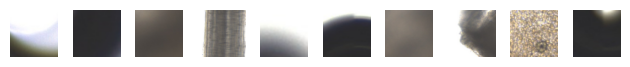

In [ ]:
plotimg(X_train[:10], 10) #plotimgs test

In [19]:
from keras import datasets, layers, models

cnn = models.Sequential([
    layers.Conv2D(filters=32, kernel_size=(5, 5), activation='relu', input_shape=(100, 100, 3)), #1st conv layers,
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'), #2nd conv layer
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(2128, activation='relu'), #1st fully connected layers
    layers.Dropout(0.5),
    layers.Dense(2128, activation='relu'), #2nd dense layer
    layers.Dropout(0.5),
    layers.Dense(4, activation='sigmoid') #activation layer
])

cnn.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy']) #compiler

cnn_history = cnn.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val)) #model trainer

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 7s 108ms/step - accuracy: 0.2738 - loss: 0.5926 - val_accuracy: 0.3544 - val_loss: 0.5379
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.3927 - loss: 0.5093 - val_accuracy: 0.5965 - val_loss: 0.4265
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.6219 - loss: 0.3937 - val_accuracy: 0.6737 - val_loss: 0.3518
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.7561 - loss: 0.3048 - val_accuracy: 0.6772 - val_loss: 0.3507
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.8046 - loss: 0.2402 - val_accuracy: 0.7649 - val_loss: 0.2592
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.7930 - loss: 0.2376 - val_accuracy: 0.7719 - val_loss: 0.2571
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.7955 - loss: 0.2266 - val_accuracy: 0.7439 - val_loss: 0.2697
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.8167 - loss: 0.2134 - val_accuracy: 0.7789 - 

In [29]:
cnn.evaluate(X_val, y_val) #validation accuracy

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8621 - loss: 0.1641


[0.18091805279254913, 0.859649121761322]

In [28]:
#[1. 0. 0. 0. 0.] - 0 - nale
#[0. 1. 0. 0. 0.] - 1 - qufu
#[0. 0. 1. 0. 0.] - 2 - erci
#[0. 0. 0. 1. 0.] - 3 - bubble
#[0. 0. 0. 0. 1.] - 4 - qufu stem

y_predicted_val = cnn.predict(X_val) #model prediction on validation
y_predicted_labels = tf.keras.utils.to_categorical(np.argmax(y_predicted_val, axis=1), num_classes=4) #one hot categorical predictions
y_predicted_rounded_percent = np.round(y_predicted_val, decimals=2) #rounded percents

#Print outs
print("Predicted percentages labels for validation")
print(y_predicted_rounded_percent[:4])
print("\nLabels the model predicted for validation")
print(y_predicted_labels[:4])
print("\nActual labels for validation")
print(y_val[:4])

class_percentages_list = []

# Iterate over each unique true class
for true_class in range(4):  # 4 classes
    # Find indices of samples belonging to the current true class
    indices = np.where(np.argmax(y_val, axis=1) == true_class)[0]

    # Get predicted probabilities for samples of the current true class
    class_probs = y_predicted_val[indices]

    # Calculate average percentages for each predicted class
    avg_percentages = np.mean(class_probs, axis=0) * 100

    #Rounds percents
    rounded_percentages = np.round(avg_percentages, decimals=1)

    #Appends to list
    class_percentages_list.append(rounded_percentages)

#Creates a numpy array of list
class_percentages = np.array(class_percentages_list)

print("\nHow the model performed for each class in validation data")
print(class_percentages)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Predicted percentages labels for validation
[[0.08 0.01 0.88 0.03]
 [0.09 0.01 0.87 0.03]
 [0.   0.01 0.   0.99]
 [0.02 0.01 0.97 0.  ]]

Labels the model predicted for validation
[[0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]]

Actual labels for validation
[[0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]]

How the model performed for each class in validation data
[[46.8 13.2 34.7  6. ]
 [12.7 81.3  4.7  2.2]
 [12.5  3.8 80.3  2.5]
 [ 1.   1.1  0.1 97. ]]


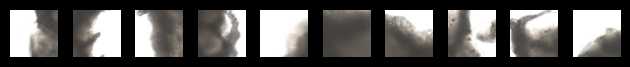

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 720ms/step
[[0.01 0.95 0.   0.02]
 [0.55 0.07 0.01 0.04]
 [0.13 0.81 0.03 0.  ]
 [0.05 0.94 0.01 0.  ]
 [0.11 0.09 0.   0.76]
 [0.01 0.99 0.   0.  ]
 [0.01 0.99 0.   0.  ]
 [0.78 0.33 0.02 0.  ]
 [0.37 0.91 0.   0.  ]
 [0.   0.85 0.   0.13]]


In [27]:
indices = np.where(np.all(y_val == [0, 1, 0, 0], axis=1))[0] #change where the 1 is to change what feature you're looking at

# Get the images corresponding to the selected indices
selected_images = X_val[indices][40:50]

# Plot the selected images using the plotimg function
plotimg(selected_images, 10)

predicted_labels = cnn.predict(selected_images)
predicted_labels_rounded = np.round(predicted_labels, decimals=2)

# Print the predicted labels
print(predicted_labels_rounded)

In [31]:
#Model predictions for the simulated new images data
test_datagen = ImageDataGenerator(rescale=1./255) # Normalize test data

test = test_datagen.flow_from_directory(
    newpath,
    target_size=image_size,
    batch_size=4200,
    class_mode='categorical'
)

X_test, y_test = test[0]# Extract test data and labels

X_test = X_test / 255.0

print(X_test.shape)

y_predicted = cnn.predict(X_test)
y_predicted_rounded = np.round(y_predicted, decimals=2) #rounded percents
print(y_predicted_rounded[:50])

Found 4199 images belonging to 1 classes.
(4199, 100, 100, 3)
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
[[0.18 0.02 0.78 0.  ]
 [0.12 0.01 0.83 0.02]
 [0.07 0.01 0.89 0.03]
 [0.12 0.01 0.81 0.04]
 [0.11 0.01 0.82 0.04]
 [0.02 0.99 0.   0.  ]
 [0.07 0.01 0.89 0.03]
 [0.17 0.01 0.81 0.  ]
 [0.08 0.01 0.87 0.03]
 [0.64 0.16 0.16 0.  ]
 [0.17 0.01 0.76 0.04]
 [0.03 0.   0.96 0.  ]
 [0.44 0.05 0.29 0.15]
 [0.09 0.01 0.86 0.04]
 [0.64 0.37 0.05 0.  ]
 [0.73 0.33 0.04 0.  ]
 [0.05 0.   0.95 0.  ]
 [0.   0.   1.   0.  ]
 [0.01 0.   0.99 0.  ]
 [0.09 0.01 0.87 0.03]
 [0.16 0.68 0.01 0.07]
 [0.08 0.   0.92 0.  ]
 [0.63 0.06 0.29 0.  ]
 [0.   0.   1.   0.  ]
 [0.44 0.02 0.55 0.  ]
 [0.   1.   0.   0.  ]
 [0.13 0.01 0.81 0.03]
 [0.07 0.   0.95 0.  ]
 [0.64 0.12 0.22 0.  ]
 [0.03 0.   0.97 0.  ]
 [0.07 0.96 0.   0.  ]
 [0.04 0.01 0.94 0.01]
 [0.07 0.01 0.9  0.02]
 [0.   0.   0.99 0.  ]
 [0.01 0.01 0.99 0.  ]
 [0.05 0.   0.94 0.  ]
 [0.42 0.01 0.46 0.05]
 [0.02 0.   0.98 0.  ]
 [0.   0.   1.   0.  ]


In [38]:
class_averages = np.mean(y_predicted, axis=0) #For new images, averages out all the predictions for each class
print(f"Nale Percent: {class_averages[0] * 100:.2f}")
print(f"Qufu Percent: {class_averages[1] * 100:.2f}")
print(f"Erci Percent: {class_averages[2] * 100:.2f}")
print(f"Bubble Percent: {class_averages[3] * 100:.2f}")

Nale Percent: 20.09
Qufu Percent: 17.68
Erci Percent: 59.29
Bubble Percent: 3.67


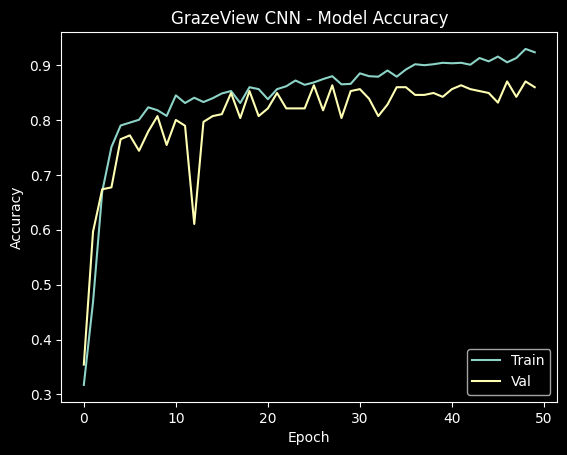

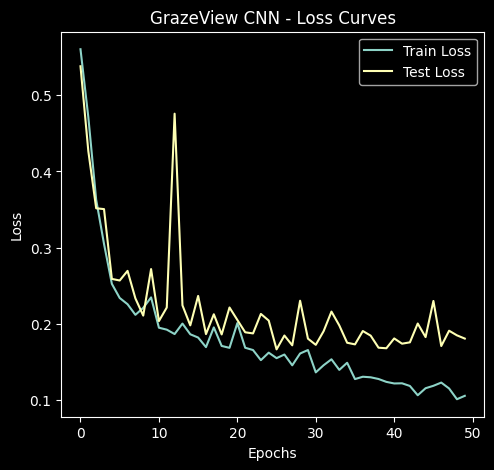

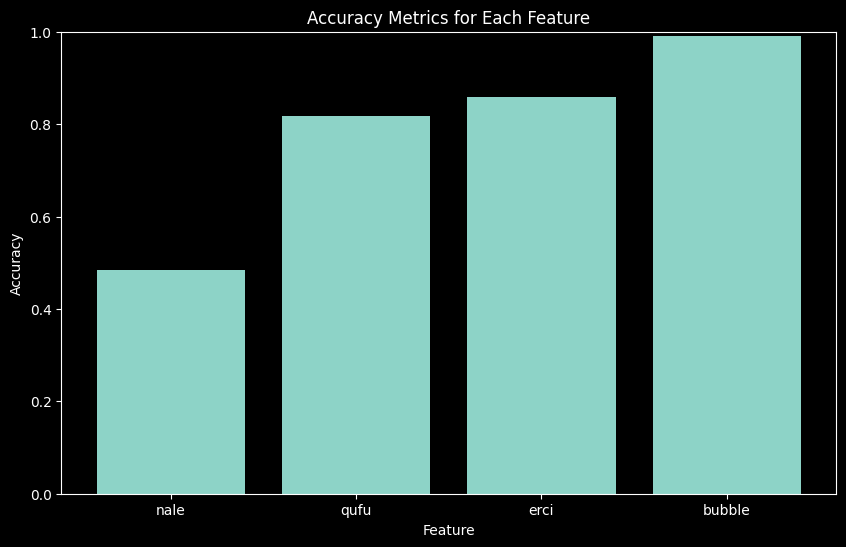

In [24]:
plt.style.use('dark_background')

#Plots the overall model accuracy
plt.plot(cnn_history.history['accuracy'])
plt.plot(cnn_history.history['val_accuracy'])
plt.title('GrazeView CNN - Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='lower right')
plt.show()

#Plots the overall model loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(cnn_history.history['loss'], label='Train Loss')
plt.plot(cnn_history.history['val_loss'], label='Test Loss')
plt.title('GrazeView CNN - Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Assuming y_val and y_predicted_val are defined as in your provided code

num_classes = y_val.shape[1]  # Get the number of classes (4 in your case)
class_names = ['nale', 'qufu', 'erci', 'bubble']  # Define class names

# Calculate accuracy for each class separately
class_accuracies = []
for class_index in range(num_classes):
    # Find indices where true label matches the current class
    true_indices = np.where(y_val[:, class_index] == 1)[0]

    # Get predicted labels for the corresponding indices
    predicted_labels = y_predicted_val[true_indices, class_index]

    # Calculate accuracy for the current class
    accuracy = np.mean(predicted_labels.round() == y_val[true_indices, class_index])
    class_accuracies.append(accuracy)

# Plot the accuracies
plt.style.use('dark_background')  # Optional: Set dark background style
plt.figure(figsize=(10, 6))  # Optional: Adjust figure size
plt.bar(class_names, class_accuracies)
plt.title('Accuracy Metrics for Each Feature')
plt.xlabel('Feature')
plt.ylabel('Accuracy')
plt.ylim([0, 1])  # Set y-axis limits to 0-1 for accuracy
plt.show()

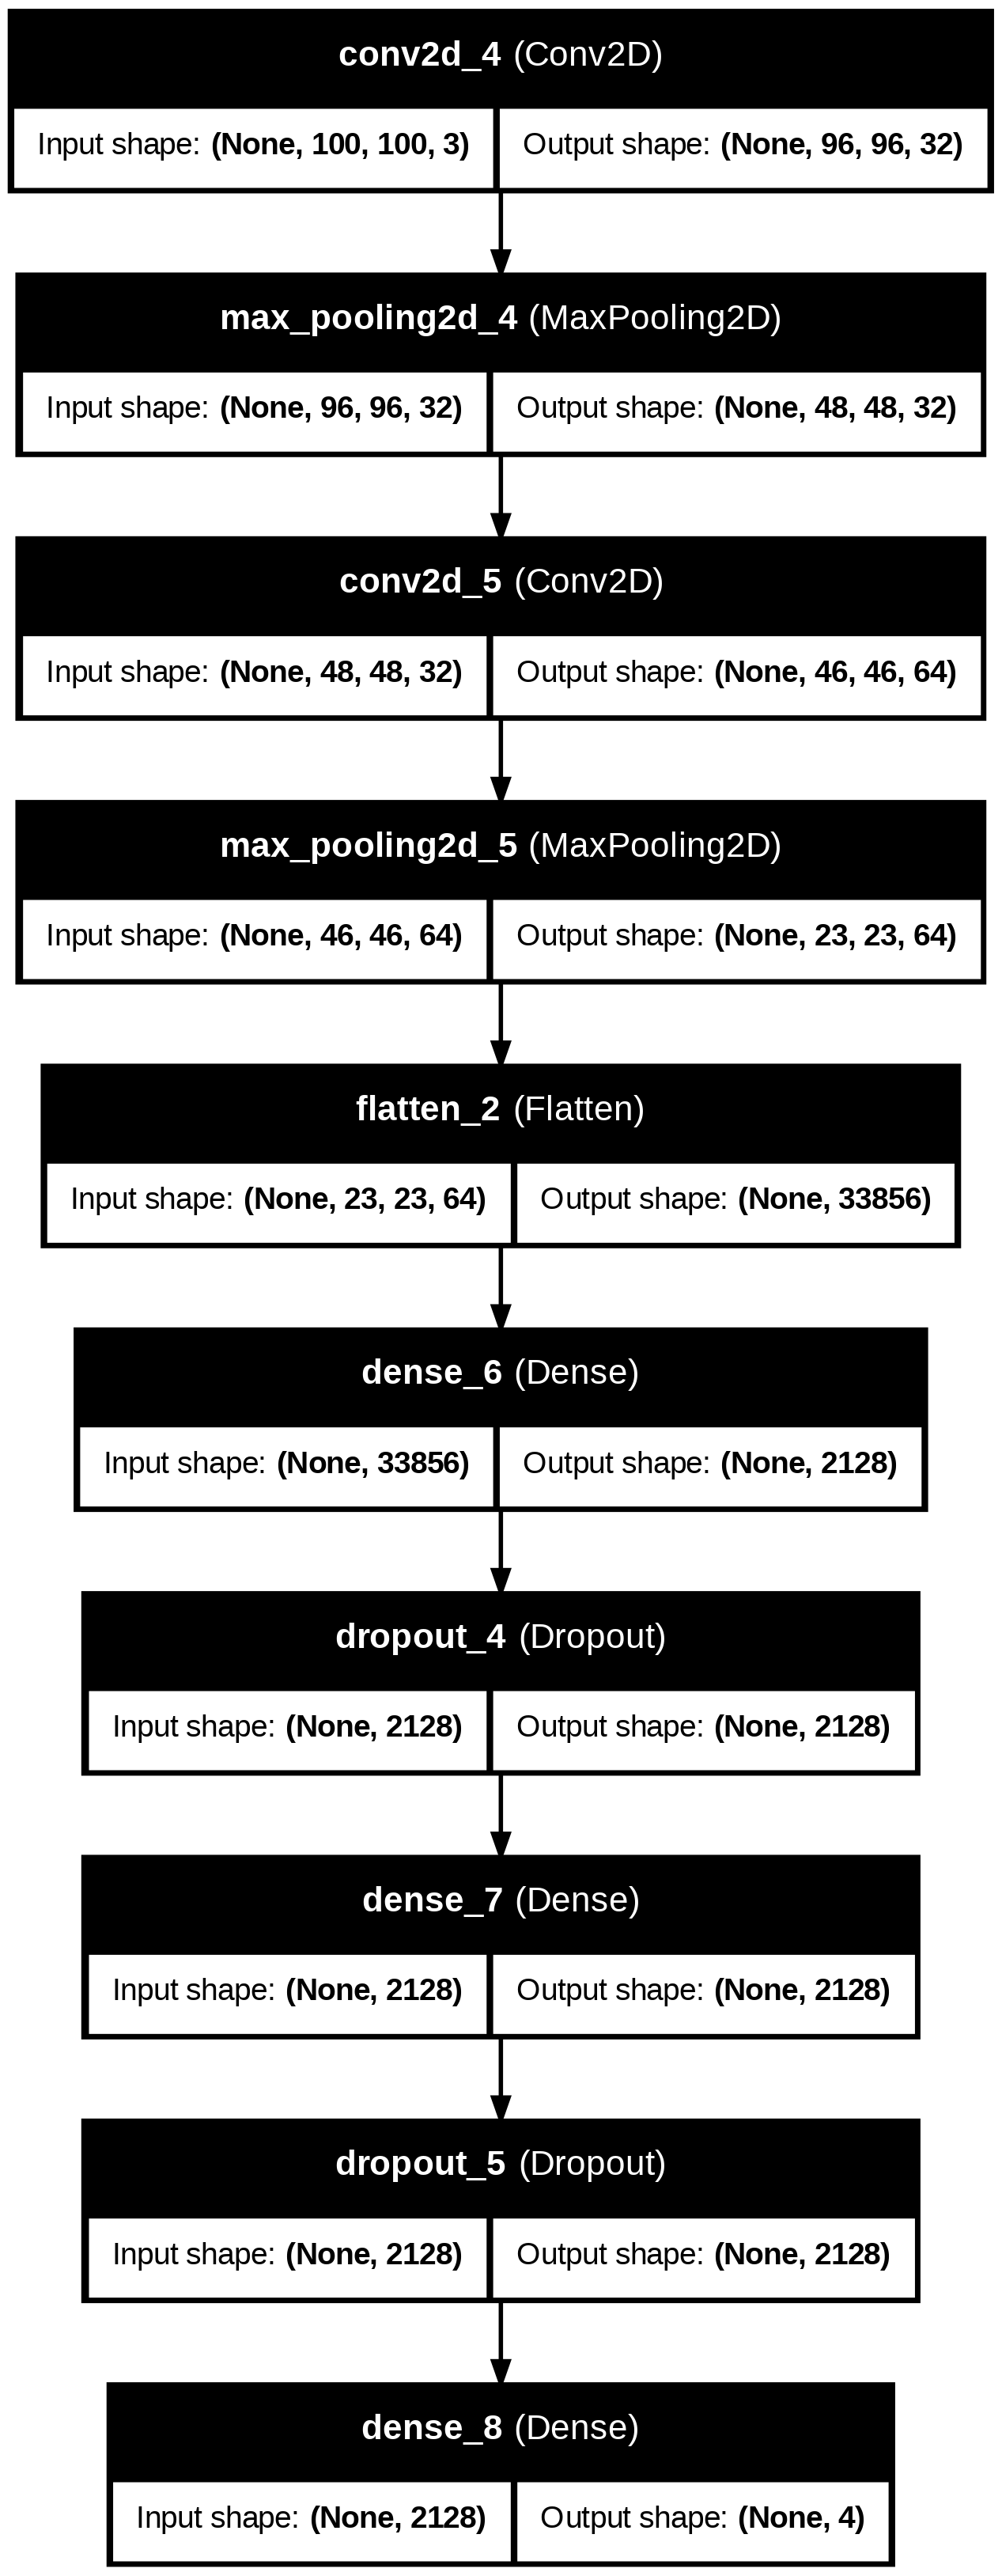

In [14]:
#Creates a layout of model architecture
plot_model(cnn, to_file='model_dark.png', show_shapes=True,
           show_layer_names=True, rankdir='TB')